In [1]:
import pandas as pd

logins = pd.read_json('logins.json')

In [2]:
logins['login_time'] = pd.to_datetime(logins['login_time'], errors = 'coerce')

In [3]:
# https://stephenallwright.com/python-round-time-15-minutes/
from datetime import datetime, timedelta
import numpy as np

def floor_dt(dt, delta):
    return datetime.min + np.floor((dt - datetime.min) / delta) * delta

delta = timedelta(minutes=15)
logins['login_time_rounded'] = [floor_dt(x.to_pydatetime(), delta) for x in logins['login_time']]

In [4]:
login_groups = logins['login_time_rounded'].value_counts(sort=False)
login_groups = pd.DataFrame(login_groups).reset_index().rename(columns={'index': 'login_time', 'login_time_rounded': 'login_count'})
login_groups.sort_values(by=['login_time'], inplace=True)

# Some login times have 0 count, need to be included here.
all_dt = pd.DataFrame()
all_dt['all_login_times'] = pd.date_range(start='1970-01-01 20:00', end ='1970-04-13 18:45', freq='15min') #max/min logins of login_groups
login_groups.shape, all_dt.shape

((9381, 2), (9788, 1))

In [5]:
# Merge login count data to list of all possible login times, fill missing values w/ 0 logins
all_dt = all_dt.merge(login_groups, left_on='all_login_times', right_on='login_time', 
                   how='outer', suffixes=('_left', '_right'))
all_dt['login_count'].fillna(0, inplace=True)
login_groups = all_dt[['all_login_times', 'login_count']].rename(columns={'all_login_times': 'login_time'})

In [6]:
# https://stackoverflow.com/questions/43855474/changing-sort-in-value-counts
login_groups.set_index('login_time', inplace=True)
login_groups

,login_count
login_time,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0
...,...
1970-04-13 17:45:00,5.0
1970-04-13 18:00:00,5.0
1970-04-13 18:15:00,2.0


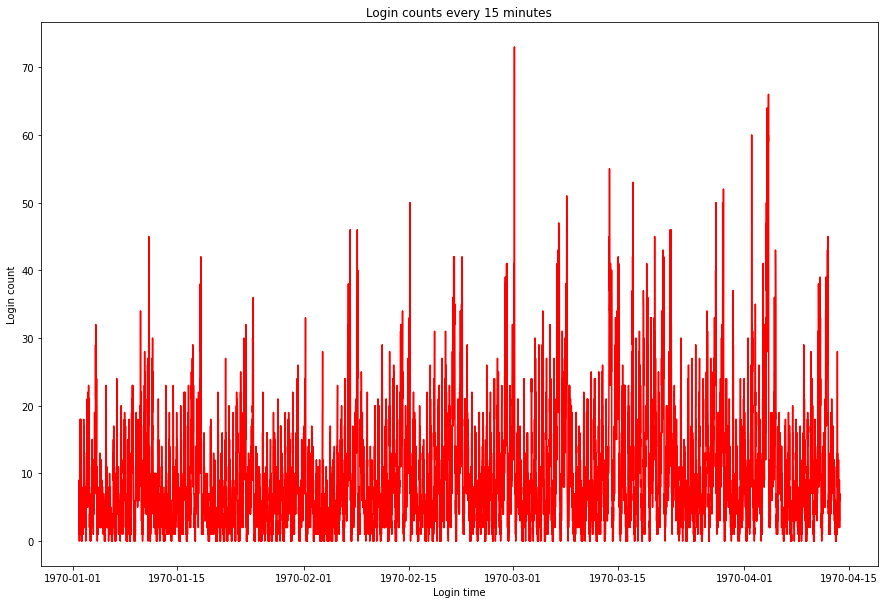

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.title("Login counts every 15 minutes")
plt.xlabel("Login time")
plt.ylabel("Login count")
plt.plot(login_groups.index, login_groups['login_count'], color ="red")
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller
# https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/
# Ho: It is non stationary
# H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")

adfuller_test(login_groups['login_count'])

ADF Test Statistic : -10.337954309060452
p-value : 2.732396654222946e-18
#Lags Used : 38
Number of Observations Used : 9749
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


c:\Users\natha\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


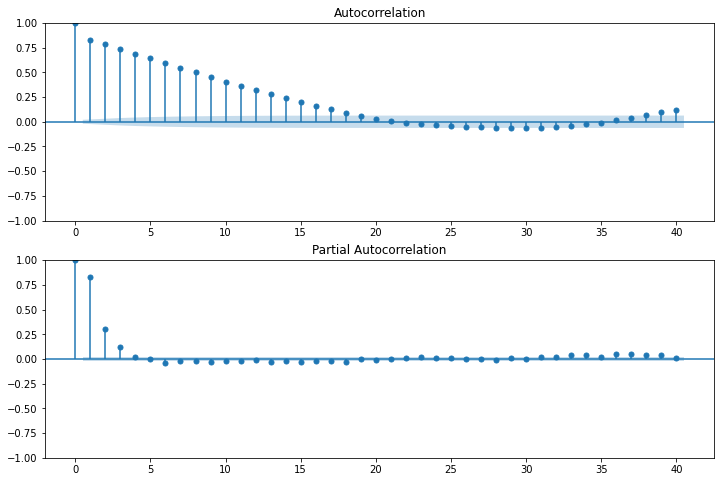

In [9]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(login_groups['login_count'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(login_groups['login_count'],lags=40,ax=ax2)

In [10]:
# For non-seasonal data
#p=1 (AR specification), d=1 (Integration order), q=0 or 1 (MA specification/polynomial)
# AR specification, Integration order, MA specification
from statsmodels.tsa.arima.model import ARIMA

login_groups.index = pd.DatetimeIndex(login_groups.index).to_period('min') # set frequency for ARIMA model
model=ARIMA(login_groups['login_count'],order=(5,1,0))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            login_count   No. Observations:                 9788
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -28506.637
Date:                Wed, 01 Mar 2023   AIC                          57025.275
Time:                        08:38:38   BIC                          57068.408
Sample:                    01-01-1970   HQIC                         57039.891
                         - 04-13-1970                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4284      0.007    -64.138      0.000      -0.441      -0.415
ar.L2         -0.1840      0.007    -26.068      0.000      -0.198      -0.170
ar.L3         -0.0657      0.008     -8.274      0.000      -0.081      -0.050
ar.L4         -0.0265      0.008     -3.320      0.001      -0.042      -0.011
ar.L5          0.0053      0.008      0.656      0.512      -0.010       0.021
sigma2        19.8386      0.172    115.643      0.000      19.502      20.175
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5797.93
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

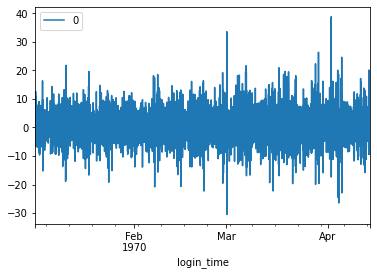

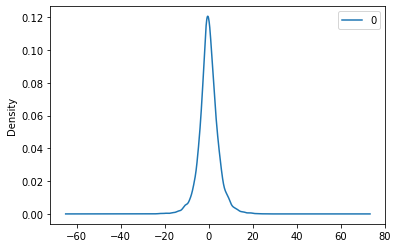

                 0
count  9788.000000
mean      0.000810
std       4.453871
min     -30.458754
25%      -2.333662
50%      -0.145302
75%       2.267385
max      38.760202


In [11]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

<AxesSubplot:xlabel='login_time'>

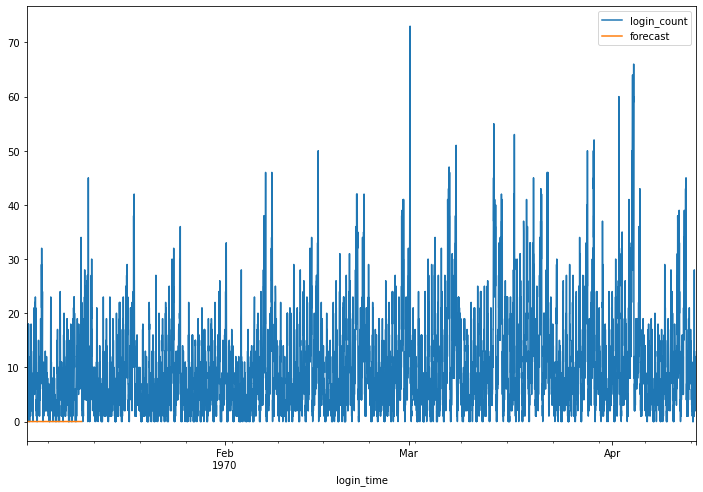

In [12]:
login_groups['forecast']=model_fit.predict(start=-0,end=800,dynamic=True)
login_groups[['login_count','forecast']].plot(figsize=(12,8))